<a href="https://colab.research.google.com/github/fender8185/Stock-predict/blob/main/lstm2stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install FinMind==1.5.4

In [3]:
import tensorflow as tf
import numpy as np
import FinMind
from FinMind.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import date


/usr/local/lib/python3.10/dist-packages/FinMind/strategies/base.py:423: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def final_stats(self) -> pd.Series():
/usr/local/lib/python3.10/dist-packages/FinMind/strategies/base.py:450: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def compare_market_stats(self) -> pd.Series():


In [4]:
params = {
        'stock_id': '0050',
        'start_date': '2018-01-01',
        'end_date': date.today()

    }

data_loader = DataLoader()
stock_data = data_loader.taiwan_stock_daily(**params)
stock_data = data_loader.feature.add_kline_institutional_investors(
    stock_data
)
stock_data = data_loader.feature.add_kline_margin_purchase_short_sale(
    stock_data
)
selected_columns = ['Foreign_Investor_diff','Margin_Purchase_diff','Investment_Trust_diff', 'close' ]
filtered_data = stock_data[selected_columns]
numpy_array = filtered_data.values
all_dates = stock_data['date'].values[1:]

In [5]:
price_diff = numpy_array[1:, -1] - numpy_array[:-1, -1]
y = price_diff
X = numpy_array[:-1]

split_index = int(len(X) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
train_dates = all_dates[:split_index]
test_dates = all_dates[split_index:]

# 數據歸一化
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# 重塑數據以供LSTM使用
timesteps = 5
X_train_reshaped = []
y_train_reshaped = []
for i in range(len(X_train_scaled) - timesteps):
    X_train_reshaped.append(X_train_scaled[i:i+timesteps])
    y_train_reshaped.append(y_train_scaled[i+timesteps])
X_train_reshaped = np.array(X_train_reshaped)
y_train_reshaped = np.array(y_train_reshaped)

X_test_reshaped = []
y_test_reshaped = []
for i in range(len(X_test_scaled) - timesteps):
    X_test_reshaped.append(X_test_scaled[i:i+timesteps])
    y_test_reshaped.append(y_test_scaled[i+timesteps])
X_test_reshaped = np.array(X_test_reshaped)
y_test_reshaped = np.array(y_test_reshaped)

# LSTM模型
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train_reshaped, y_train_reshaped, epochs=5000, batch_size=32)

# 預測
y_pred_train_scaled = model.predict(X_train_reshaped)
y_pred_test_scaled = model.predict(X_test_reshaped)

# 反縮放預測值回原始尺度
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)


串流輸出內容已截斷至最後 5000 行。
35/35 [==============================] - 0s 14ms/step - loss: 1.0291e-04
Epoch 2503/5000
35/35 [==============================] - 0s 13ms/step - loss: 1.7180e-04
Epoch 2504/5000
35/35 [==============================] - 0s 13ms/step - loss: 1.3656e-04
Epoch 2505/5000
35/35 [==============================] - 0s 13ms/step - loss: 1.8614e-04
Epoch 2506/5000
35/35 [==============================] - 0s 13ms/step - loss: 1.3609e-04
Epoch 2507/5000
35/35 [==============================] - 0s 13ms/step - loss: 3.6330e-04
Epoch 2508/5000
35/35 [==============================] - 0s 14ms/step - loss: 3.0569e-04
Epoch 2509/5000
35/35 [==============================] - 0s 13ms/step - loss: 1.9952e-04
Epoch 2510/5000
35/35 [==============================] - 0s 14ms/step - loss: 1.1776e-04
Epoch 2511/5000
35/35 [==============================] - 0s 13ms/step - loss: 7.4400e-05
Epoch 2512/5000
35/35 [==============================] - 0s 14ms/step - loss: 4.7938e-05
Epoch 2513/5000


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 調整日期以匹配預測值
adjusted_train_dates = train_dates[timesteps:]
adjusted_test_dates = test_dates[timesteps:]

fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Data', 'Testing Data with Predictions'))

# 添加訓練數據到第一個子圖
fig.add_trace(go.Scatter(x=adjusted_train_dates, y=y_train[timesteps:], mode='lines', name='Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=adjusted_train_dates, y=y_pred_train.flatten(), mode='lines', name='Predicted Training Data', marker=dict(symbol='circle-open')), row=1, col=1)

# 添加測試數據的真實值到第二個子圖
fig.add_trace(go.Scatter(x=adjusted_test_dates, y=y_test[timesteps:], mode='lines', name='Real Test Values'), row=1, col=2)
fig.add_trace(go.Scatter(x=adjusted_test_dates, y=y_pred_test.flatten(), mode='lines', name='Predicted Test Values', marker=dict(symbol='circle-open')), row=1, col=2)

fig.update_layout(hovermode='x unified')

# 顯示圖形
fig.show()


In [7]:
# 計算累計的預測價差，以得到預測的close價格
predicted_train_close = numpy_array[timesteps:1+split_index, -1][:-1] + y_pred_train.flatten()
predicted_test_close = numpy_array[split_index + timesteps:, -1][:-1] + y_pred_test.flatten()

import plotly.graph_objects as go

# 繪製原始的close和預測的close
fig = go.Figure()

# 添加原始的close價格
fig.add_trace(go.Scatter(x=all_dates[timesteps:], y=numpy_array[timesteps:, -1], mode='lines', name='Original Close Price'))

# 添加訓練數據的預測close價格
fig.add_trace(go.Scatter(x=train_dates[timesteps+1:], y=predicted_train_close, mode='lines', name='Predicted Train Close Price'))

# 添加測試數據的預測close價格
fig.add_trace(go.Scatter(x=test_dates[timesteps+1:], y=predicted_test_close, mode='lines', name='Predicted Test Close Price'))

fig.update_layout(hovermode='x unified', title='Original vs Predicted Close Price')

# 顯示圖形
fig.show()


In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 計算累積的價差
cumulative_train_diff = np.cumsum(y_train[timesteps:])
cumulative_test_diff = np.cumsum(y_test[timesteps:])
cumulative_pred_train_diff = np.cumsum(y_pred_train.flatten())
cumulative_pred_test_diff = np.cumsum(y_pred_test.flatten())

# 調整日期以匹配預測值
adjusted_train_dates = train_dates[timesteps:]
adjusted_test_dates = test_dates[timesteps:]

fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Data', 'Testing Data with Predictions'))

# 添加訓練數據到第一個子圖
fig.add_trace(go.Scatter(x=adjusted_train_dates, y=cumulative_train_diff, mode='lines', name='Cumulative Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=adjusted_train_dates, y=cumulative_pred_train_diff, mode='lines', name='Predicted Cumulative Training Data', marker=dict(symbol='circle-open')), row=1, col=1)

# 添加測試數據的真實值到第二個子圖
fig.add_trace(go.Scatter(x=adjusted_test_dates, y=cumulative_test_diff, mode='lines', name='Cumulative Real Test Values'), row=1, col=2)
fig.add_trace(go.Scatter(x=adjusted_test_dates, y=cumulative_pred_test_diff, mode='lines', name='Predicted Cumulative Test Values', marker=dict(symbol='circle-open')), row=1, col=2)

fig.update_layout(hovermode='x unified')

# 顯示圖形
fig.show()


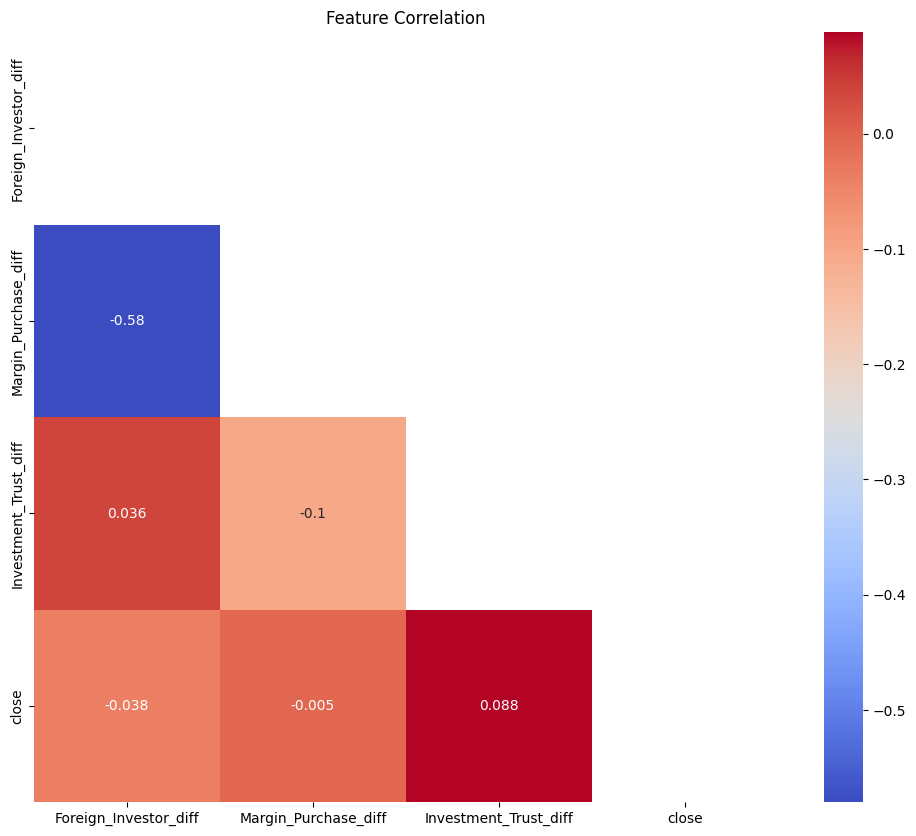

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 計算特徵之間的相關性
correlation_matrix = filtered_data.corr()

# 創建一個布爾遮罩，只顯示下三角形部分
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 使用seaborn的heatmap功能繪製熱圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Feature Correlation')
plt.show()
